This notebook evaluates StereoMapper performance against a context-aware reconciliation framework (MetaNetX). The results generated here are associated with figure 6.

In [2]:
import pandas as pd
import sqlite3
import json
from collections import defaultdict, Counter
from typing import Dict, List, Any, Set, Optional
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [ ]:
# load the mnx structures
mnx_structures_with_mappings = 'structure_mappings_for_comp.sqlite' # additional file 3 from manuscript

# create connection
conn = sqlite3.connect(mnx_structures_with_mappings)
cursor = conn.cursor()

# generate dataframe of mnx mappings
q = " SELECT * FROM mnx_structures_with_maps"
mnx_strucs = pd.read_sql_query(q, conn)
mnx_strucs

,mnx_ref,dedup_label
0,https://rdf.metanetx.org/chem/BIOMASS,seedM:cpd11416
1,https://rdf.metanetx.org/chem/MNXM02,vmhM:oh1
2,https://rdf.metanetx.org/chem/MNXM02,chebi:13365
3,https://rdf.metanetx.org/chem/MNXM02,chebi:13419
4,https://rdf.metanetx.org/chem/MNXM02,chebi:16234
...,...,...
1433900,https://rdf.metanetx.org/chem/MNXM1584859,keggC:C13429
1433901,https://rdf.metanetx.org/chem/MNXM1584859,keggD:D01940
1433902,https://rdf.metanetx.org/chem/MNXM1584860,seedM:cpd09432
1433903,https://rdf.metanetx.org/chem/MNXM1584861,chebi:71305


In [ ]:
db_path = "stereomapper_output.sqlite" # Additional file 1 from manuscript
conn = sqlite3.connect(db_path)

# get vals from cluster table as it is all that is needed for this comparison
query = "SELECT * FROM clusters;"
df_molD = pd.read_sql_query(query, conn)
df_molD.head()

,cluster_id,is_undef_sru,is_def_sru,sru_repeat_count,member_count,members_json,members_hash
0,1,0,0,NaN,1,"[""SLM:000736507""]",db55be2239bd2eac03bb254a780c704ee87055d839e77b...
1,2,0,0,NaN,1,"[""SLM:000496071""]",0830b68b759c58b051c0feb193175c757e5e5a1692ac11...
2,3,0,0,NaN,1,"[""SLM:000491467""]",36e33cded4fa84438dc10a439001c7566b068adcf29343...
3,4,0,0,NaN,1,"[""SLM:000512033""]",c995e07bef761cf6d20a89ff3ef8b262b590caf1403226...
4,5,0,0,NaN,3,"[""chebi:80858"", ""keggC:C17009"", ""seedM:cpd17277""]",4cbda1ea6824f5b36c0cd005ca63f490be347642181d10...


In [18]:
# close connection
conn.close()

In the dataframe, `df_molD`, we have a set of clusters each denoted by a cluster id and also their associated members. If a cluster has one member, it means stereomapper found this structure to be a unique structure in the dataset i.e it was not found to be identical to any other structure in the dataset. 

If a cluster has more than one member, stereomapper found the opposite scenario, these structures are deemed to be identical.


This dataset also needs a little bit of cleaning to fit to the standard formatting of identifiers we extracted from ReconXKG.

In [19]:
# extract json list from members_json 
df_molD['members'] = df_molD['members_json'].apply(json.loads)
df_molD = df_molD.drop(columns=['members_json'])
df_molD.head()

,cluster_id,is_undef_sru,is_def_sru,sru_repeat_count,member_count,members_hash,members
0,1,0,0,NaN,1,db55be2239bd2eac03bb254a780c704ee87055d839e77b...,[SLM:000736507]
1,2,0,0,NaN,1,0830b68b759c58b051c0feb193175c757e5e5a1692ac11...,[SLM:000496071]
2,3,0,0,NaN,1,36e33cded4fa84438dc10a439001c7566b068adcf29343...,[SLM:000491467]
3,4,0,0,NaN,1,c995e07bef761cf6d20a89ff3ef8b262b590caf1403226...,[SLM:000512033]
4,5,0,0,NaN,3,4cbda1ea6824f5b36c0cd005ca63f490be347642181d10...,"[chebi:80858, keggC:C17009, seedM:cpd17277]"


Now both datasets are in the same format for comparison, great!

## Compare stereomapper clustering to ReconXKG clustering

To faciliate this, every identifier in each cluster from stereomapper needs to be extracted from `df_molD` and cross-referenced to an identifier in `df_dedup`. This will allow us to compare the stereomapper clustering against the MetaNetX clustering method by comparing clusters directly.

In [ ]:
# extract all distinct clusters members from identity_clusters
all_members = []
for members in df_molD['members']:
    all_members.append(members)

# now extract 'mnx_id' and 'label' from df_dedup
mnx_structs_dict = dict(zip(mnx_strucs['dedup_label'], mnx_strucs['mnx_ref']))

In [22]:
def build_mnx_index(dedup_dict: Dict[str, str]) -> Dict[str, Set[str]]:
    """Invert label->MNX mapping to MNX->set(labels)."""
    mnx_to_labels = defaultdict(set)
    for label, mnx in dedup_dict.items():
        mnx_to_labels[mnx].add(label)
    return mnx_to_labels

def compare_clusters_to_mnx(
    clusters: List[List[str]],
    dedup_dict: Dict[str, str],
    show_progress: bool = True
) -> List[Dict[str, Any]]:
    """
    Compare each stereomapper cluster (list of labels) to MetaNetX groupings from dedup_dict.

    Labels (mutually exclusive):
      - exact_agreement:         cluster_set == mnx_related
      - mnx_superset_agreement:  cluster_set  ⊂ mnx_related
      - stereomapper_superset_agreement: mnx_related ⊂ cluster_set
      - mnx_id_disagreement:     >1 MNX id among labels present in dict
      - partial_overlap_unmapped: 1 MNX id, but some cluster labels are unmapped in dict
      - no_overlap_with_dict:    none of the cluster labels are in dict
    """
    mnx_to_labels = build_mnx_index(dedup_dict)
    results = []

    iterator = tqdm(clusters, desc="Comparing clusters", unit="cluster") if show_progress else clusters

    for cluster in iterator:
        cluster_list = list(cluster)  # preserve user order for reporting
        cluster_set = set(cluster_list)

        # Partition cluster into dict-mapped vs unmapped
        present = [lbl for lbl in cluster_list if lbl in dedup_dict]
        unmapped = sorted(cluster_set - set(present))

        hit_mnx_ids = {dedup_dict[lbl] for lbl in present}
        support_count = len(present)
        cluster_size = len(cluster_list)
        support_frac  = support_count / cluster_size if cluster_size else 0.0

        # Fast exits
        if support_count == 0:
            classification = "no_overlap_with_dict"
            results.append({
                "cluster": cluster_list,
                "present_in_dict": [],
                "unmapped_in_dict": unmapped,
                "mnx_ids_hit": [],
                "support_count": 0,
                "cluster_size": cluster_size,
                "support_fraction": 0.0,
                "overlap_size": 0,
                "jaccard_cluster_vs_mnx": 0.0,
                "related_labels_by_mnx": {},
                "mnx_minus_cluster": [],
                "cluster_minus_mnx": [],
                "all_related_labels_union": [],
                "classification": classification,
            })
            continue

        if len(hit_mnx_ids) > 1:
            # Your 'disagreement' case — multiple MNX ids claimed inside one cluster
            related_by_mnx = {mnx: sorted(mnx_to_labels[mnx]) for mnx in hit_mnx_ids}
            all_related_union = sorted(set().union(*(set(v) for v in related_by_mnx.values())))
            results.append({
                "cluster": cluster_list,
                "present_in_dict": sorted(present),
                "unmapped_in_dict": unmapped,
                "mnx_ids_hit": sorted(hit_mnx_ids),
                "support_count": support_count,
                "cluster_size": cluster_size,
                "support_fraction": support_frac,
                "overlap_size": len(set(present)),  # overlap with dict-mapped labels
                "jaccard_cluster_vs_mnx": 0.0,     # undefined for multi-MNX; leave 0.0
                "related_labels_by_mnx": related_by_mnx,
                "mnx_minus_cluster": [],           # undefined for multi-MNX; leave empty
                "cluster_minus_mnx": [],
                "all_related_labels_union": all_related_union,
                "classification": "mnx_id_disagreement",
            })
            continue

        # Single MNX id path
        mnx = next(iter(hit_mnx_ids))
        mnx_related_set = set(mnx_to_labels[mnx])
        # Set differences both ways
        mnx_minus_cluster = sorted(mnx_related_set - cluster_set)
        cluster_minus_mnx = sorted(cluster_set - mnx_related_set)

        # Similarity (on sets), safe for zeros
        union = len(mnx_related_set | cluster_set)
        inter = len(mnx_related_set & cluster_set)
        jaccard = (inter / union) if union else 1.0

        # Labeling logic
        if unmapped:
            # Some labels in the cluster aren't even in the dict — keep this explicit.
            classification = "partial_overlap_unmapped"
        elif mnx_related_set == cluster_set:
            classification = "exact_agreement"
        elif cluster_set < mnx_related_set:
            classification = "mnx_superset_agreement"              # stereomapper ⊂ MNX
        elif mnx_related_set < cluster_set:
            classification = "stereomapper_superset_agreement"      # stereomapper ⊃ MNX
        else:
            # Shouldn't really happen given above cases, but keep a safe default
            classification = "partial_overlap_unmapped" if unmapped else "mnx_superset_agreement" if len(mnx_minus_cluster) else "stereomapper_superset_agreement"

        results.append({
            "cluster": cluster_list,
            "present_in_dict": sorted(present),
            "unmapped_in_dict": unmapped,
            "mnx_ids_hit": [mnx],
            "primary_mnx": mnx,  # explicit surface
            "support_count": support_count,
            "cluster_size": cluster_size,
            "support_fraction": support_frac,
            "overlap_size": inter,
            "jaccard_cluster_vs_mnx": jaccard,
            "related_labels_by_mnx": {mnx: sorted(mnx_related_set)},
            "mnx_minus_cluster": mnx_minus_cluster,  # MNX has these extra labels
            "cluster_minus_mnx": cluster_minus_mnx,  # stereomapper has these extra labels
            "all_related_labels_union": sorted(mnx_related_set),
            "classification": classification,
        })

    return results


In [23]:
results = compare_clusters_to_mnx(all_members, mnx_structs_dict)

Comparing clusters: 100%|██████████| 987926/987926 [00:10<00:00, 97023.61cluster/s] 


In [24]:
results

[{'cluster': ['SLM:000736507'],
  'present_in_dict': ['SLM:000736507'],
  'unmapped_in_dict': [],
  'mnx_ids_hit': ['https://rdf.metanetx.org/chem/MNXM1044118'],
  'primary_mnx': 'https://rdf.metanetx.org/chem/MNXM1044118',
  'support_count': 1,
  'cluster_size': 1,
  'support_fraction': 1.0,
  'overlap_size': 1,
  'jaccard_cluster_vs_mnx': 1.0,
  'related_labels_by_mnx': {'https://rdf.metanetx.org/chem/MNXM1044118': ['SLM:000736507']},
  'mnx_minus_cluster': [],
  'cluster_minus_mnx': [],
  'all_related_labels_union': ['SLM:000736507'],
  'classification': 'exact_agreement'},
 {'cluster': ['SLM:000496071'],
  'present_in_dict': ['SLM:000496071'],
  'unmapped_in_dict': [],
  'mnx_ids_hit': ['https://rdf.metanetx.org/chem/MNXM446350'],
  'primary_mnx': 'https://rdf.metanetx.org/chem/MNXM446350',
  'support_count': 1,
  'cluster_size': 1,
  'support_fraction': 1.0,
  'overlap_size': 1,
  'jaccard_cluster_vs_mnx': 1.0,
  'related_labels_by_mnx': {'https://rdf.metanetx.org/chem/MNXM446350'

In [25]:
def _sets_from_row(r: Dict[str, Any]):
    C = set(r.get("cluster", []) or [])
    M = set(r.get("all_related_labels_union", []) or [])
    return C, M

def _tp_fp_fn(C, M):
    tp = len(C & M)
    fp = len(M - C)           # MNX extras (mnx_minus_cluster count)
    fn = len(C - M)           # cluster extras (cluster_minus_mnx count)
    return tp, fp, fn

def summarize_results(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Works with rows shaped like your schema, e.g.:
      'cluster', 'present_in_dict', 'unmapped_in_dict', 'mnx_ids_hit', 'primary_mnx',
      'support_count', 'cluster_size', 'support_fraction', 'overlap_size',
      'jaccard_cluster_vs_mnx', 'related_labels_by_mnx',
      'mnx_minus_cluster', 'cluster_minus_mnx',
      'all_related_labels_union', 'classification'
    """
    # Per-row derived counts (kept separate; original rows untouched)
    derived = []
    for r in results:
        C, M = _sets_from_row(r)
        tp, fp, fn = _tp_fp_fn(C, M)

        # Use provided jaccard if present; else compute
        union = len(C | M)
        jacc = r.get("jaccard_cluster_vs_mnx")
        if jacc is None:
            jacc = (tp / union) if union else math.nan

        # For multi-MNX disagreements you may prefer to NaN scores; leaving as-is (union-based)
        purity_cluster = (tp / len(C)) if len(C) else math.nan
        coverage_mnx   = (tp / len(M)) if len(M) else math.nan
        f1 = (
            (2 * purity_cluster * coverage_mnx) / (purity_cluster + coverage_mnx)
            if all(x == x for x in (purity_cluster, coverage_mnx)) and (purity_cluster + coverage_mnx) > 0
            else math.nan
        )

        derived.append({
            "tp": tp, "fp": fp, "fn": fn,
            "jaccard": jacc,
            "purity_cluster": purity_cluster,
            "coverage_mnx": coverage_mnx,
            "f1": f1,
        })

    # Overview tallies
    by_class = Counter(r.get("classification", "unclassified") for r in results)

    # Micro (instance-level)
    tot_tp = sum(d["tp"] for d in derived)
    tot_fp = sum(d["fp"] for d in derived)
    tot_fn = sum(d["fn"] for d in derived)
    micro_purity   = tot_tp / (tot_tp + tot_fn) if (tot_tp + tot_fn) else math.nan   # |C∩M| / |C|
    micro_coverage = tot_tp / (tot_tp + tot_fp) if (tot_tp + tot_fp) else math.nan   # |C∩M| / |M|
    micro_f1 = (
        (2 * micro_purity * micro_coverage) / (micro_purity + micro_coverage)
        if all(x == x for x in (micro_purity, micro_coverage)) and (micro_purity + micro_coverage) > 0
        else math.nan
    )

    # Macro means (ignore NaN)
    def _mean(vs):
        vs = [v for v in vs if isinstance(v, (int, float)) and v == v]
        return sum(vs)/len(vs) if vs else math.nan

    macro_f1    = _mean([d["f1"] for d in derived])
    macro_jacc  = _mean([d["jaccard"] for d in derived])
    macro_purit = _mean([d["purity_cluster"] for d in derived])
    macro_cov   = _mean([d["coverage_mnx"] for d in derived])

    # Namespace-level disagreement totals (from the two diffs already in your schema)
    ns_fp_tot = defaultdict(int); ns_fn_tot = defaultdict(int)
    for r in results:
        for x in r.get("mnx_minus_cluster", []) or []:
            ns = x.split(":", 1)[0].lower() if ":" in x else ""
            ns_fp_tot[ns] += 1
        for x in r.get("cluster_minus_mnx", []) or []:
            ns = x.split(":", 1)[0].lower() if ":" in x else ""
            ns_fn_tot[ns] += 1
    fp_sum = sum(ns_fp_tot.values()) or 1
    fn_sum = sum(ns_fn_tot.values()) or 1
    fp_by_ns = {ns: {"count": c, "pct": c/fp_sum} for ns, c in sorted(ns_fp_tot.items(), key=lambda x: -x[1])}
    fn_by_ns = {ns: {"count": c, "pct": c/fn_sum} for ns, c in sorted(ns_fn_tot.items(), key=lambda x: -x[1])}

    # Worst offenders (by total disagreement size)
    disagreement_scores = [
        (i, derived[i]["fp"] + derived[i]["fn"]) for i in range(len(results))
    ]
    worst_idx = [i for i, _ in sorted(disagreement_scores, key=lambda t: -t[1])[:25]]
    worst = [results[i] | {"tp": derived[i]["tp"], "fp": derived[i]["fp"], "fn": derived[i]["fn"]} for i in worst_idx]

    # Flat DataFrame with ONLY your schema’s names (plus tp/fp/fn & derived scores for convenience)
    rows = []
    for r, d in zip(results, derived):
        rows.append({
            "cluster": "|".join(r.get("cluster", [])),
            "present_in_dict": "|".join(r.get("present_in_dict", [])),
            "unmapped_in_dict": "|".join(r.get("unmapped_in_dict", [])),
            "mnx_ids_hit": "|".join(r.get("mnx_ids_hit", [])),
            "primary_mnx": r.get("primary_mnx", ""),
            "classification": r.get("classification", "unclassified"),
            "support_count": r.get("support_count", math.nan),
            "cluster_size": r.get("cluster_size", math.nan),
            "support_fraction": r.get("support_fraction", math.nan),
            "overlap_size": r.get("overlap_size", math.nan),
            "jaccard_cluster_vs_mnx": r.get("jaccard_cluster_vs_mnx", d["jaccard"]),
            "mnx_minus_cluster": "|".join(r.get("mnx_minus_cluster", [])),
            "cluster_minus_mnx": "|".join(r.get("cluster_minus_mnx", [])),
            # helpful extras (keep names separate from your schema keys)
            "tp": d["tp"], "fp": d["fp"], "fn": d["fn"],
            "purity_cluster": d["purity_cluster"],
            "coverage_mnx": d["coverage_mnx"],
            "f1": d["f1"],
        })
    df = pd.DataFrame(rows)

    return {
        "overview": {
            "by_classification": dict(by_class),
            "micro": {"purity_cluster": micro_purity, "coverage_mnx": micro_coverage, "f1": micro_f1},
            "macro": {"purity_cluster": macro_purit, "coverage_mnx": macro_cov, "f1": macro_f1, "jaccard": macro_jacc},
            "totals": {"TP": tot_tp, "FP": tot_fp, "FN": tot_fn},
        },
        "namespace_disagreements": {"fp_by_ns": fp_by_ns, "fn_by_ns": fn_by_ns},
        "worst_offenders_top25": worst,
        "flat_df": df,
    }


In [26]:
summary = summarize_results(results)

df = summary["flat_df"]
df


,cluster,present_in_dict,unmapped_in_dict,mnx_ids_hit,primary_mnx,classification,support_count,cluster_size,support_fraction,overlap_size,jaccard_cluster_vs_mnx,mnx_minus_cluster,cluster_minus_mnx,tp,fp,fn,purity_cluster,coverage_mnx,f1
0,SLM:000736507,SLM:000736507,,https://rdf.metanetx.org/chem/MNXM1044118,https://rdf.metanetx.org/chem/MNXM1044118,exact_agreement,1,1,1.0,1,1.000000,,,1,0,0,1.0,1.000000,1.000000
1,SLM:000496071,SLM:000496071,,https://rdf.metanetx.org/chem/MNXM446350,https://rdf.metanetx.org/chem/MNXM446350,exact_agreement,1,1,1.0,1,1.000000,,,1,0,0,1.0,1.000000,1.000000
2,SLM:000491467,SLM:000491467,,https://rdf.metanetx.org/chem/MNXM446347,https://rdf.metanetx.org/chem/MNXM446347,exact_agreement,1,1,1.0,1,1.000000,,,1,0,0,1.0,1.000000,1.000000
3,SLM:000512033,SLM:000512033,,https://rdf.metanetx.org/chem/MNXM822853,https://rdf.metanetx.org/chem/MNXM822853,exact_agreement,1,1,1.0,1,1.000000,,,1,0,0,1.0,1.000000,1.000000
4,chebi:80858|keggC:C17009|seedM:cpd17277,chebi:80858|keggC:C17009|seedM:cpd17277,,https://rdf.metanetx.org/chem/MNXM62681,https://rdf.metanetx.org/chem/MNXM62681,exact_agreement,3,3,1.0,3,1.000000,,,3,0,0,1.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987921,chebi:64493,chebi:64493,,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,mnx_superset_agreement,1,1,1.0,1,0.333333,chebi:64514|seedM:cpd22804,,1,2,0,1.0,0.333333,0.500000
987922,chebi:64514|seedM:cpd22804,chebi:64514|seedM:cpd22804,,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,mnx_superset_agreement,2,2,1.0,2,0.666667,chebi:64493,,2,1,0,1.0,0.666667,0.800000
987923,hmdb:HMDB0243532,hmdb:HMDB0243532,,https://rdf.metanetx.org/chem/MNXM44853,https://rdf.metanetx.org/chem/MNXM44853,mnx_superset_agreement,1,1,1.0,1,0.250000,chebi:3197|keggC:C08754|seedM:cpd05659,,1,3,0,1.0,0.250000,0.400000
987924,chebi:3197|keggC:C08754|seedM:cpd05659,chebi:3197|keggC:C08754|seedM:cpd05659,,https://rdf.metanetx.org/chem/MNXM44853,https://rdf.metanetx.org/chem/MNXM44853,mnx_superset_agreement,3,3,1.0,3,0.750000,hmdb:HMDB0243532,,3,1,0,1.0,0.750000,0.857143


In [27]:
df.value_counts('classification')

classification
exact_agreement             850733
mnx_superset_agreement      134211
mnx_id_disagreement           2073
no_overlap_with_dict           617
partial_overlap_unmapped       292
Name: count, dtype: int64

In [28]:
def detect_fragmentation(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Post-pass audit over your schema to find MNX groups split across multiple clusters.

    Returns:
      {
        "mnx_to_clusters": {mnx_id: sorted(list_of_cluster_idxs)},
        "fragmented_mnx":  {mnx_id: {"num_clusters": k, "cluster_idxs": [...]}},
        "cluster_flags":   {cluster_idx: {"fragmented_for_primary_mnx": bool,
                                          "num_clusters_for_primary_mnx": int,
                                          "missing_members_in_other_clusters": sorted([...])}},
        "summary":         {"num_fragmented_mnx": int,
                            "num_clusters_flagged": int,
                            "mnx_superset_agreement_that_are_fragmented": int}
      }
    """
    # 1) Build label -> cluster_idx map
    label_to_cluster = {}
    for i, row in enumerate(results):
        for lbl in row.get("cluster", []):
            label_to_cluster[lbl] = i

    # 2) For each row with a single MNX id, get the MNX "ground-truth" set
    #    (from your row['related_labels_by_mnx'][mnx]) and see how many distinct
    #    clusters those labels are spread across.
    mnx_to_clusters = defaultdict(set)
    mnx_to_all_related = {}
    for i, row in enumerate(results):
        mnx_ids = row.get("mnx_ids_hit", []) or []
        if len(mnx_ids) != 1:
            continue
        mnx = mnx_ids[0]
        rel = set(row.get("related_labels_by_mnx", {}).get(mnx, []))
        if not rel:
            continue
        mnx_to_all_related[mnx] = rel  # they should all be identical across rows that hit this MNX
        for lbl in rel:
            if lbl in label_to_cluster:
                mnx_to_clusters[mnx].add(label_to_cluster[lbl])

    # 3) Fragmented MNX groups are those spanning >1 cluster
    fragmented_mnx = {
        mnx: {"num_clusters": len(idxs), "cluster_idxs": sorted(idxs)}
        for mnx, idxs in mnx_to_clusters.items() if len(idxs) > 1
    }

    # 4) Per-cluster flags: if row is mnx_superset_agreement (or exact/other),
    #    annotate whether its primary MNX is fragmented globally and which "extras"
    #    are actually located in other clusters.
    cluster_flags = {}
    fragmented_superset_count = 0
    for i, row in enumerate(results):
        mnx_ids = row.get("mnx_ids_hit", []) or []
        primary = row.get("primary_mnx") or (mnx_ids[0] if len(mnx_ids) == 1 else None)
        cluster_set = set(row.get("cluster", []))
        extras_mnx  = set(row.get("mnx_minus_cluster", []))  # MNX minus this cluster (already in your schema)

        fragmented = False
        num_clusters_for_primary = 1
        missing_members_in_other_clusters = []

        if primary and primary in fragmented_mnx:
            fragmented = True
            num_clusters_for_primary = fragmented_mnx[primary]["num_clusters"]
            # Which of this row's MNX-extras are sitting in other clusters?
            for lbl in extras_mnx:
                j = label_to_cluster.get(lbl)
                if j is not None and j != i:
                    missing_members_in_other_clusters.append(lbl)

        cluster_flags[i] = {
            "fragmented_for_primary_mnx": fragmented,
            "num_clusters_for_primary_mnx": num_clusters_for_primary,
            "missing_members_in_other_clusters": sorted(missing_members_in_other_clusters),
        }

        if fragmented and row.get("classification") == "mnx_superset_agreement":
            fragmented_superset_count += 1

    summary = {
        "num_fragmented_mnx": len(fragmented_mnx),
        "num_clusters_flagged": sum(1 for v in cluster_flags.values() if v["fragmented_for_primary_mnx"]),
        "mnx_superset_agreement_that_are_fragmented": fragmented_superset_count,
    }

    return {
        "mnx_to_clusters": {k: sorted(v) for k, v in mnx_to_clusters.items()},
        "fragmented_mnx": fragmented_mnx,
        "cluster_flags": cluster_flags,
        "summary": summary,
    }


In [29]:
frag = detect_fragmentation(results)

In [30]:
frag['summary']

{'num_fragmented_mnx': 29974,
 'num_clusters_flagged': 62658,
 'mnx_superset_agreement_that_are_fragmented': 62475}

Let's account for this rate of fragmentation in the initial output. This will give a more accurate overview of the similarities and differences in terms of mapping.

In [31]:
def derive_strict_view(results: List[Dict[str, Any]], frag: Dict[str, Any]):
    """
    Buckets rows into:
      - 'strict_agreement'                 : exact_agreement
      - 'strict_disagreement'              : mnx_id_disagreement OR stereomapper_superset_agreement
                                            OR (mnx_superset_agreement AND fragmented_for_primary_mnx)
      - 'mnx_superset_agreement_actual'    : mnx_superset_agreement AND NOT fragmented (MNX truly broader)
      - 'mapping_gap'                      : partial_overlap_unmapped OR no_overlap_with_dict
      - 'other'                            : anything else (should be tiny/none)

    Also returns a compact summary and convenience DataFrames.
    """
    # indices of clusters whose primary MNX is split across multiple stereomapper clusters
    fragmented_cluster_idxs = {
        i for i, v in frag.get("cluster_flags", {}).items() if v.get("fragmented_for_primary_mnx")
    }

    labeled_rows = []
    for i, r in enumerate(results):
        base = r.get("classification", "unclassified")

        if base == "exact_agreement":
            strict_bucket = "strict_agreement"
            reason = None

        elif base in ("partial_overlap_unmapped", "no_overlap_with_dict"):
            strict_bucket = "mapping_gap"
            reason = base

        elif base == "mnx_superset_agreement":
            if i in fragmented_cluster_idxs:
                strict_bucket = "strict_disagreement"
                reason = "masked_split_fragmentation"
            else:
                strict_bucket = "mnx_superset_agreement_actual"
                reason = None

        elif base in ("mnx_id_disagreement", "stereomapper_superset_agreement"):
            strict_bucket = "strict_disagreement"
            reason = base  # over-merge or multi-MNX

        else:
            strict_bucket = "other"
            reason = base

        labeled_rows.append({**r, "strict_bucket": strict_bucket, "strict_disagreement_reason": reason})

    # Build a flat DataFrame
    flat = []
    for r in labeled_rows:
        flat.append({
            "strict_bucket": r["strict_bucket"],
            "strict_disagreement_reason": r.get("strict_disagreement_reason"),
            "classification": r.get("classification"),
            "cluster": "|".join(r.get("cluster", [])),
            "mnx_ids_hit": "|".join(r.get("mnx_ids_hit", [])),
            "primary_mnx": r.get("primary_mnx", ""),
            "mnx_minus_cluster": "|".join(r.get("mnx_minus_cluster", [])),
            "cluster_minus_mnx": "|".join(r.get("cluster_minus_mnx", [])),
            "support_count": r.get("support_count"),
            "cluster_size": r.get("cluster_size"),
            "support_fraction": r.get("support_fraction"),
        })
    df = pd.DataFrame(flat)

    # Overall counts and percentages
    total = len(df) if not df.empty else 1
    counts = df["strict_bucket"].value_counts().to_dict()
    perc = {k: v/total for k, v in counts.items()}

    # Disagreement breakdown (reason-level)
    dis_df = df[df["strict_bucket"] == "strict_disagreement"]
    dis_counts = dis_df["strict_disagreement_reason"].fillna("unspecified").value_counts().to_dict()
    dis_perc = {k: v/len(dis_df) if len(dis_df) else 0.0 for k, v in dis_counts.items()}

    # Convenience slices
    views = {
        "strict_agreement_df": df[df["strict_bucket"] == "strict_agreement"].copy(),
        "strict_disagreement_df": dis_df.copy(),
        "mnx_superset_agreement_actual_df": df[df["strict_bucket"] == "mnx_superset_agreement_actual"].copy(),
        "mapping_gap_df": df[df["strict_bucket"] == "mapping_gap"].copy(),
        "other_df": df[df["strict_bucket"] == "other"].copy(),
        "all_df": df,
    }

    summary = {
        "counts": counts,
        "percentages": perc,
        "disagreement_breakdown_counts": dis_counts,
        "disagreement_breakdown_percentages": dis_perc,
        "total_rows": len(df),
    }

    return labeled_rows, summary, views


In [33]:
labelled_res, strict_summary, strict_views = derive_strict_view(results, frag)
strict_summary

{'counts': {'strict_agreement': 850733,
  'mnx_superset_agreement_actual': 71736,
  'strict_disagreement': 64548,
  'mapping_gap': 909},
 'percentages': {'strict_agreement': 0.8611302870862797,
  'mnx_superset_agreement_actual': 0.07261272605438059,
  'strict_disagreement': 0.06533687745843313,
  'mapping_gap': 0.0009201094009065456},
 'disagreement_breakdown_counts': {'masked_split_fragmentation': 62475,
  'mnx_id_disagreement': 2073},
 'disagreement_breakdown_percentages': {'masked_split_fragmentation': 0.967884365123629,
  'mnx_id_disagreement': 0.03211563487637107},
 'total_rows': 987926}

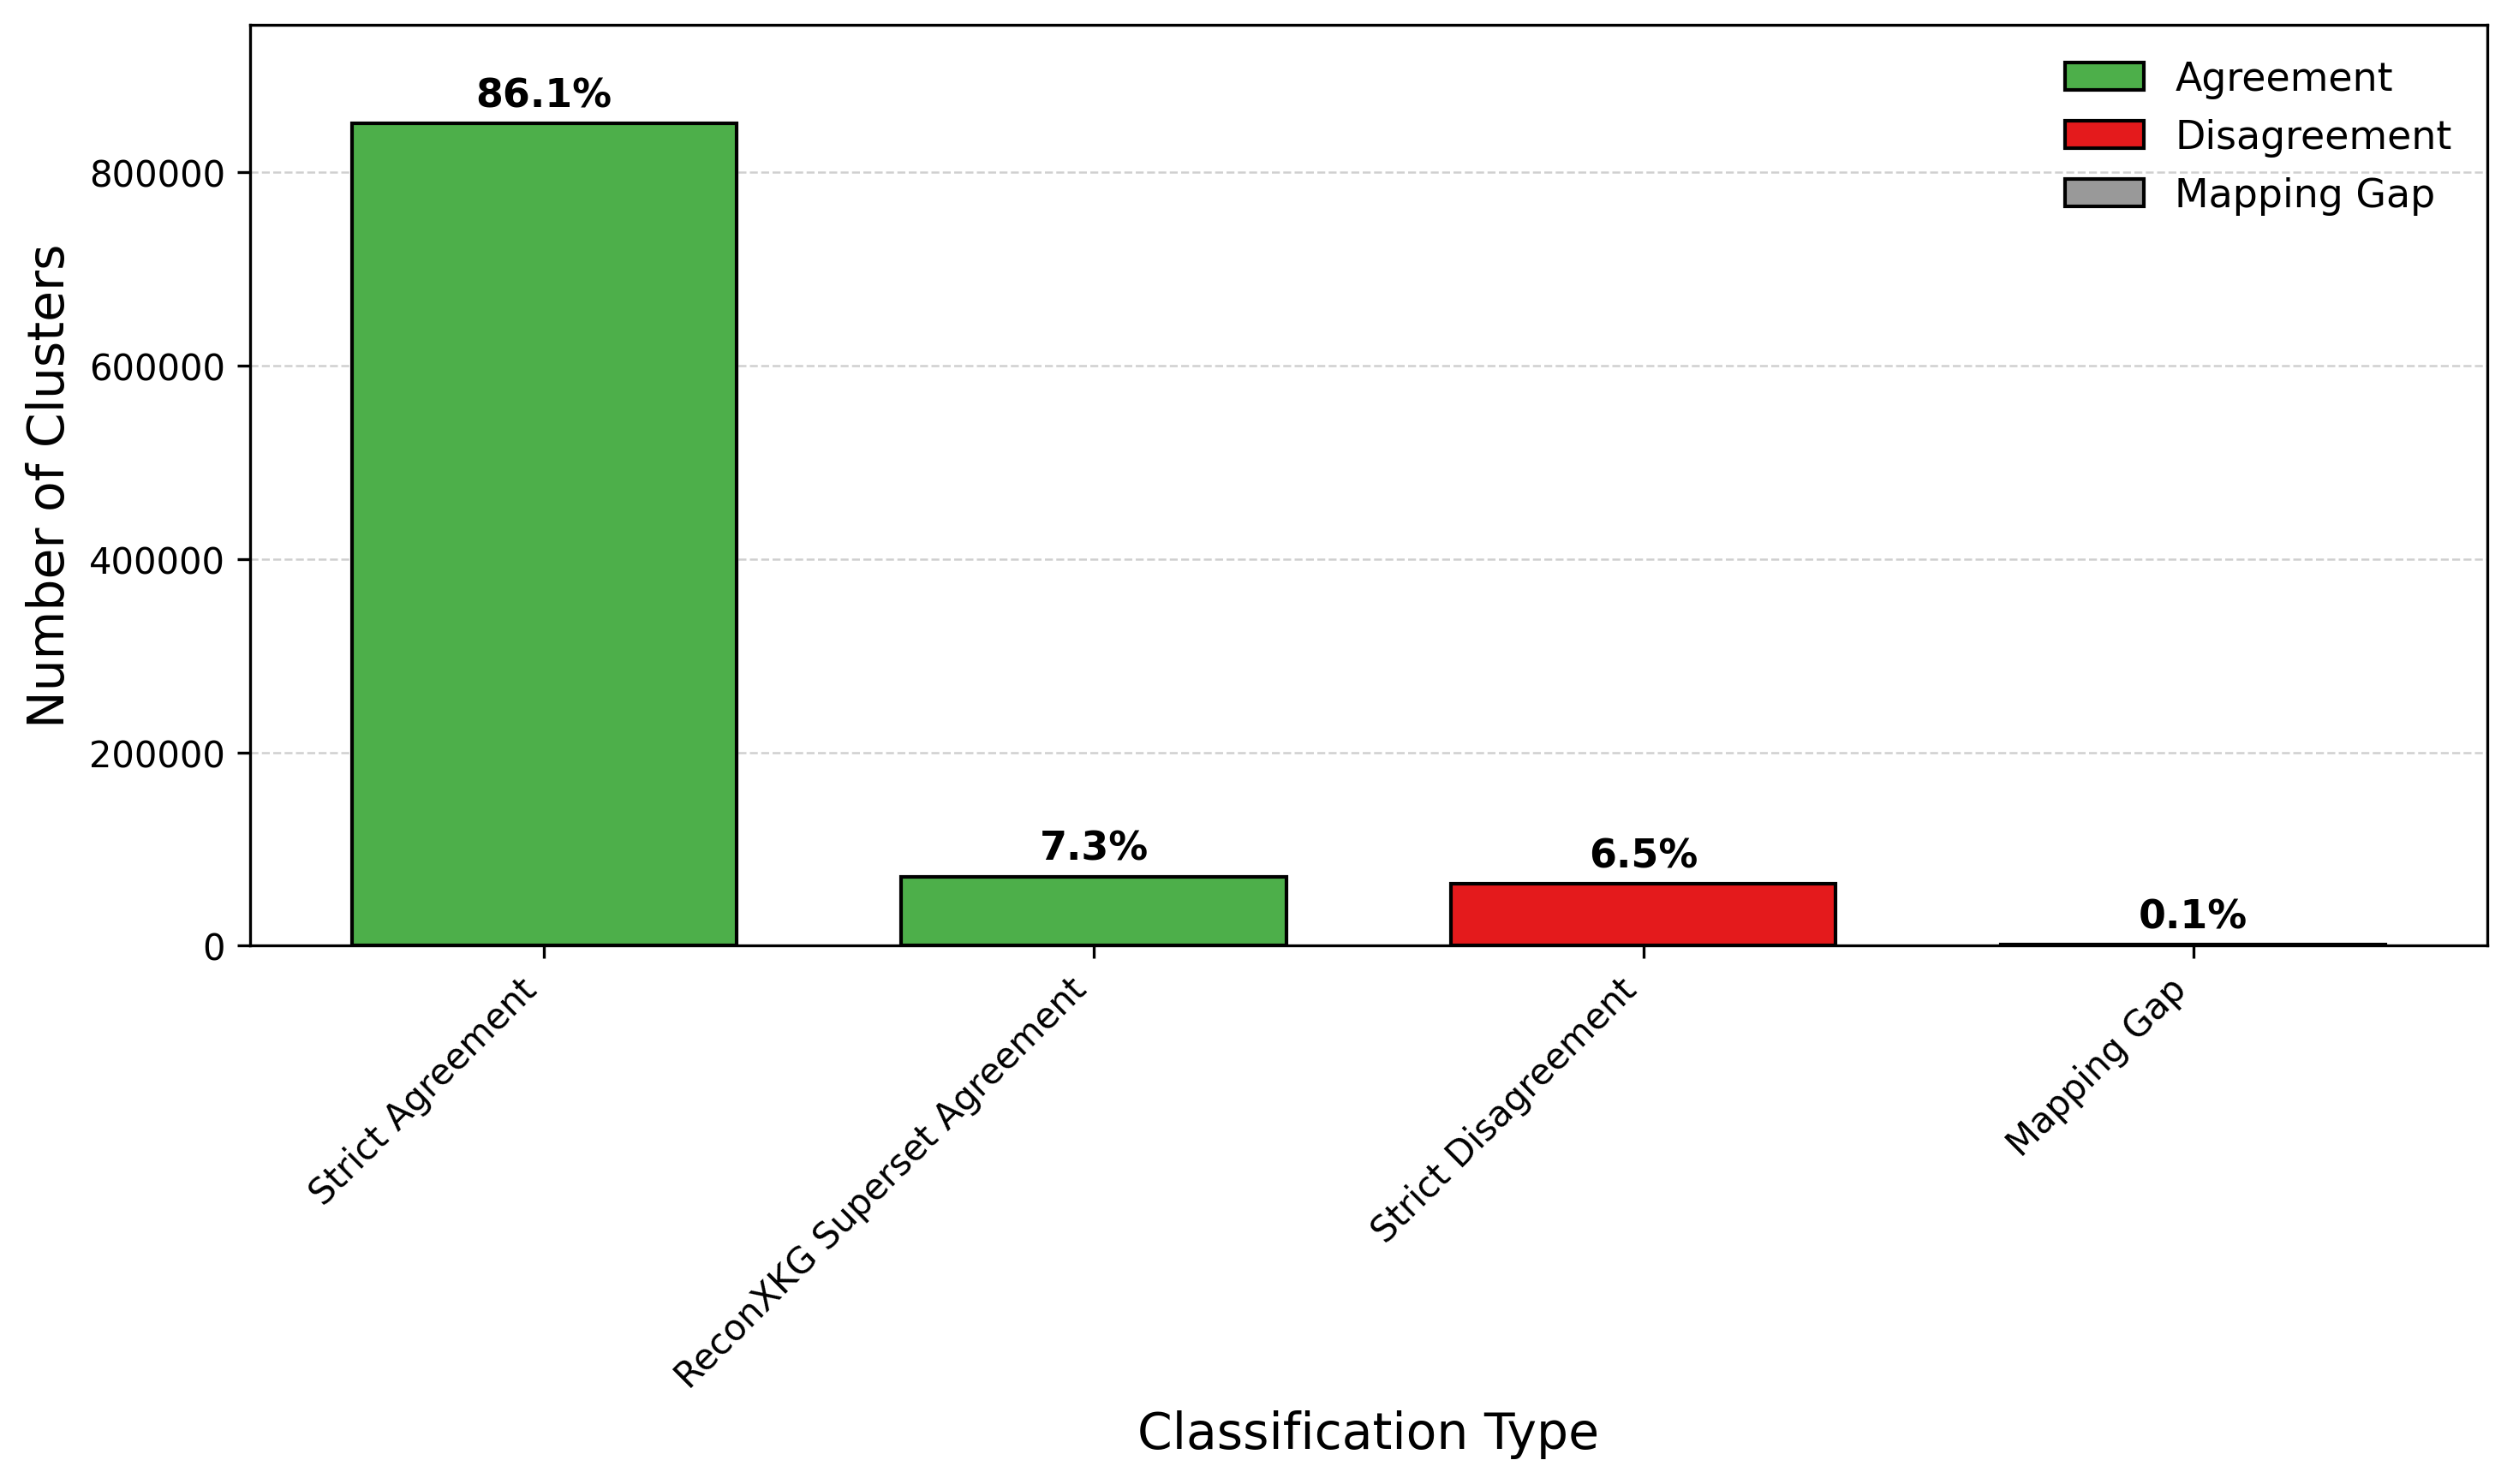

In [34]:
# replace category names for better readability
rename_map = {
    "strict_agreement": "Strict Agreement",
    "mnx_superset_agreement_actual": "ReconXKG Superset Agreement",
    "strict_disagreement": "Strict Disagreement",
    "mapping_gap": "Mapping Gap",
}

# rebuild both dicts with readable names
counts = {rename_map[k]: v for k, v in strict_summary['counts'].items() if k in rename_map}
percentages = {rename_map[k]: v for k, v in strict_summary['percentages'].items() if k in rename_map}


color_map = {
    "Strict Agreement": "#4daf4a",
    "ReconXKG Superset Agreement": "#4daf4a",
    "Strict Disagreement": "#e41a1c",
    "Mapping Gap": "#999999",
}

colors = [color_map.get(cat, "#808080") for cat in counts.keys()]

# --- Typography & figure defaults ---
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],   # substitute with a journal-preferred font if needed
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "pdf.fonttype": 42,                  # for editable text in vector outputs
    "ps.fonttype": 42,
})

legend_elements = [
    Patch(facecolor="#4daf4a", edgecolor='black', label='Agreement'),
    Patch(facecolor="#e41a1c", edgecolor='black', label='Disagreement'),
    Patch(facecolor="#999999", edgecolor='black', label='Mapping Gap')
]

# --- Build figure ---
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()

x_labels = list(counts.keys())
x = np.arange(len(x_labels))
y = np.array(list(counts.values()))

# Bars (grayscale is safe for print; edge enhances clarity)
bars = ax.bar(x, y, color=colors, width=0.7, edgecolor="black")

# Title & axes
# ax.set_title("Agreement between StereoLynx and ReconXKG mapping assignments.")
ax.set_xlabel("Classification Type")
ax.set_ylabel("Number of Clusters")

# X tick labels
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

# set the legend 
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=False, edgecolor='black', title=None)

# Add a little headroom for labels above bars
y_max = y.max() if len(y) else 1
ax.set_ylim(0, y_max * 1.12)

# Add percentage labels on each bar
for i, (cat, count) in enumerate(counts.items()):
    pct = percentages[cat] * 100
    ax.text(i, count + y_max * 0.01, f"{pct:.1f}%", ha='center',
             va='bottom', fontsize=11,
            fontweight="semibold")
    
# Gridlines to aid reading without clutter
ax.yaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)

fig.tight_layout()

plt.show()


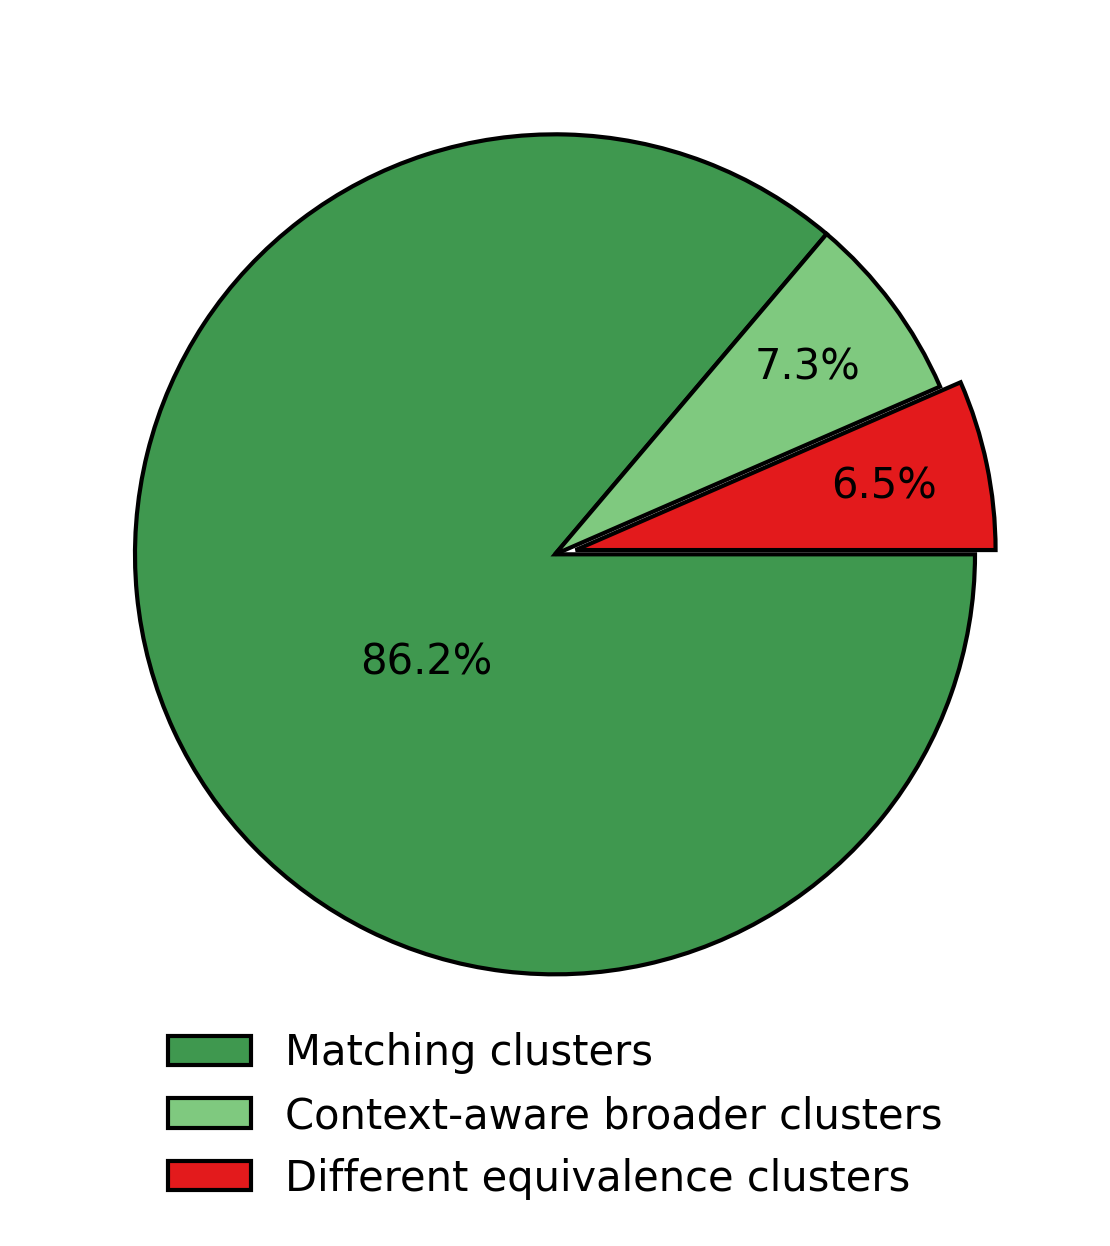

In [35]:
rename_map = {
    "strict_agreement": "Matching clusters",
    "mnx_superset_agreement_actual": "Context-aware broader clusters",
    "strict_disagreement": "Different equivalence clusters",
    "mapping_gap": "Mapping Gap",
}

counts_all = {
    rename_map[k]: v
    for k, v in strict_summary["counts"].items()
    if k in rename_map
}

percentages_all = {
    rename_map[k]: v
    for k, v in strict_summary["percentages"].items()
    if k in rename_map
}

include_labels = [
    "Matching clusters",
    "Context-aware broader clusters",
    "Different equivalence clusters",
]

counts = {k: counts_all[k] for k in include_labels}
percentages = {k: percentages_all[k] for k in include_labels}

colour_map = {
    "Matching clusters": "#3f984f",
    "Context-aware broader clusters": "#7fc97f",
    "Different equivalence clusters": "#e31a1c",
}

labels = list(counts.keys())
sizes = np.array(list(counts.values()), dtype=float)
colours = [colour_map[cat] for cat in labels]

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 12,
    "figure.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(5, 5))

explode = [0.0, 0.0, 0.05]

def autopct_with_counts(pct):
    total = sizes.sum()
    count = int(round(pct / 100.0 * total))
    return f"{pct:.1f}%"

wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    colors=colours,
    startangle=0,
    counterclock=False,
    autopct=autopct_with_counts,
    pctdistance=0.75,
    wedgeprops=dict(edgecolor="black", linewidth=1.0),
    textprops=dict(fontsize=10),
)

# Adjust Strict Agreement label as before
idx_sa = labels.index("Matching clusters")
w_sa = wedges[idx_sa]
t_sa = autotexts[idx_sa]

theta_mid = 0.5 * (w_sa.theta1 + w_sa.theta2)
theta_mid += 15
r = 0.4

x = r * np.cos(np.deg2rad(theta_mid))
y = r * np.sin(np.deg2rad(theta_mid))

t_sa.set_position((x, y))
t_sa.set_ha("center")
t_sa.set_va("center")

ax.set_aspect("equal")

ax.legend(
    wedges,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),  # same as pie 1
    ncol=1,
    frameon=False,
    fontsize=10,
)

# Same margins as pie 1
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.25)

plt.show()


In [36]:
# DataFrames you can display/export
df_agree      = strict_views["strict_agreement_df"]
df_disagree   = strict_views["strict_disagreement_df"]
df_mnx_super  = strict_views["mnx_superset_agreement_actual_df"]
df_map_gap    = strict_views["mapping_gap_df"]
df_all        = strict_views["all_df"]

In [37]:
df_disagree

,strict_bucket,strict_disagreement_reason,classification,cluster,mnx_ids_hit,primary_mnx,mnx_minus_cluster,cluster_minus_mnx,support_count,cluster_size,support_fraction
6,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,https://rdf.metanetx.org/chem/MNXM73492,SLM:000042967,,1,1,1.0
7,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,https://rdf.metanetx.org/chem/MNXM73492,lipidmapsM:LMGP04010069,,1,1,1.0
14,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,1,1,1.0
15,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:17994,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:21079|chebi:4234|chebi:58345...,,1,1,1.0
16,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:68819|hmdb:HMDB0011688|keggC:C01151,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,3,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...
987910,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:94378,https://rdf.metanetx.org/chem/MNXM172519,https://rdf.metanetx.org/chem/MNXM172519,hmdb:HMDB0248915,,1,1,1.0
987921,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:64493,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,chebi:64514|seedM:cpd22804,,1,1,1.0
987922,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:64514|seedM:cpd22804,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,chebi:64493,,2,2,1.0
987923,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,https://rdf.metanetx.org/chem/MNXM44853,chebi:3197|keggC:C08754|seedM:cpd05659,,1,1,1.0


Now lets get the reason for disagreement in each. Fit into the classes from stereomapper. This will give an indication as to the most common difference causing the disagreements in mapping. The most efficient method to give a good estimate of the reasons, is to generate inchikeys for each cluster, and mnx_minus_cluster and compare them. We could potentially use the relationships table, but it would be difficult as some of the identifiers in mnx_minus_cluster can still be secondary identifiers, causing potential errors. It also may take quite a while to run stereomapper over these again.

In [43]:
# open new connecton to the sqlite db
conn = sqlite3.connect(db_path)
# lets get the relationships table
query = "SELECT * FROM relationships;"
df_rels = pd.read_sql_query(query, conn)
df_rels.head()

,cluster_a,cluster_b,cluster_a_members,cluster_b_members,cluster_a_size,cluster_b_size,classification,score,score_details,extra_info,version_tag
0,2,3,"[""slm:SLM:496071""]","[""slm:SLM:491467""]",1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
1,7,8,"[""lipidmaps:LMGP04010069""]","[""slm:SLM:042967""]",1,1,Protomers,95.0,"{""confidence_bin"":""high""}",None,v1.0
2,11,12,"[""slm:SLM:213588""]","[""slm:SLM:213725""]",1,1,Enantiomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
3,13,14,"[""slm:SLM:452819""]","[""slm:SLM:433625""]",1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
4,15,16,"[""local:sabiork_1470""]","[""chebi:CHEBI:17994""]",1,1,Parent-child,100.0,"{""confidence_bin"":""high""}",None,v1.0


In [44]:
# replace 'Planar vs stereo defined structures' with 'Parent-child' for consistency with manuscript
df_rels['classification'] = df_rels['classification'].replace({'Planar vs stereo defined structures': 'Parent-child'})
df_rels

,cluster_a,cluster_b,cluster_a_members,cluster_b_members,cluster_a_size,cluster_b_size,classification,score,score_details,extra_info,version_tag
0,2,3,"[""slm:SLM:496071""]","[""slm:SLM:491467""]",1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
1,7,8,"[""lipidmaps:LMGP04010069""]","[""slm:SLM:042967""]",1,1,Protomers,95.0,"{""confidence_bin"":""high""}",None,v1.0
2,11,12,"[""slm:SLM:213588""]","[""slm:SLM:213725""]",1,1,Enantiomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
3,13,14,"[""slm:SLM:452819""]","[""slm:SLM:433625""]",1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
4,15,16,"[""local:sabiork_1470""]","[""chebi:CHEBI:17994""]",1,1,Parent-child,100.0,"{""confidence_bin"":""high""}",None,v1.0
...,...,...,...,...,...,...,...,...,...,...,...
339453,987901,987902,"[""chebi:CHEBI:8342"", ""hmdb:HMDB0304685"", ""kegg...","[""modelseed:cpd05473""]",3,1,Protomers,81.0,"{""confidence_bin"":""medium""}",None,v1.0
339454,987905,987906,"[""lipidmaps:LMGL03012341"", ""slm:SLM:263813""]","[""slm:SLM:263829""]",2,1,Enantiomers,100.0,"{""confidence_bin"":""high""}",None,v1.0
339455,987910,987911,"[""hmdb:HMDB0248915""]","[""chebi:CHEBI:94378""]",1,1,Parent-child,100.0,"{""confidence_bin"":""high""}",None,v1.0
339456,987922,987923,"[""chebi:CHEBI:64493""]","[""chebi:CHEBI:64514"", ""modelseed:cpd22804""]",1,2,Protomers,95.0,"{""confidence_bin"":""high""}",None,v1.0


In [45]:
# cleaning for misformatted relationship member ids (fixed in current versions of stereomapper)
def clean_member_id(member):
    # clean up the prefixes to match the format in ReconXKG
    if member.startswith("slm:SLM:"):
        return member.replace("slm:SLM:", "SLM:")
    elif member.startswith("chebi:CHEBI:"):
        return member.replace("chebi:CHEBI:", "chebi:")
    elif member.startswith("lipidmaps"):
        return member.replace("lipidmaps:", "lipidmapsM:")
    elif member.startswith("kegg.compound"):
        return member.replace("kegg.compound:", "keggC:")
    elif member.startswith("kegg.drug"):
        return member.replace("kegg.drug:", "keggD:")
    elif member.startswith("vmhmetabolite:"):
        return member.replace("vmhmetabolite:", "vmhM:")
    elif member.startswith("sabiork:"):
        return member.replace("sabiork:", "sabiorkM:")
    elif member.startswith("modelseed:"):
        return member.replace("modelseed:", "seedM:")
    else:
        return member
    
def replace_local_prefix(member):
    if member.startswith("local:"):
        # check if the rest of the id is numeric only
        rest = member.split("local:")[1]
        if rest.startswith("sabiork") or rest.isdigit():
            # remove sabirok_ if it exists
            rest = rest.replace("sabiork_", "")
            return f"sabiorkM:{rest}"
        else:
            return f"vmhM:{rest}"
    return member

def fix_slm_id(slm_id):
    if slm_id.startswith("SLM:"):
        parts = slm_id.split(":")
        if len(parts) == 2 and parts[1].isdigit():
            number = parts[1]
            # add three leading zeros to the number
            fixed_number = "000" + number
            return f"SLM:{fixed_number}"
    return slm_id

In [ ]:
# need to do the same cleaning as before
df_rels['cluster_a_members'] = df_rels['cluster_a_members'].apply(json.loads)
df_rels['cluster_b_members'] = df_rels['cluster_b_members'].apply(json.loads)

# now clean them 
df_rels['cleaned_cluster_a'] = df_rels['cluster_a_members'].apply(lambda members: [clean_member_id(m) for m in members])
df_rels['cleaned_cluster_b'] = df_rels['cluster_b_members'].apply(lambda members: [clean_member_id(m) for m in members])
# drop the old columns
df_rels = df_rels.drop(columns=['cluster_a_members', 'cluster_b_members'])

,cluster_a,cluster_b,cluster_a_size,cluster_b_size,classification,score,score_details,extra_info,version_tag,cleaned_cluster_a,cleaned_cluster_b
0,2,3,1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0,[SLM:496071],[SLM:491467]
1,7,8,1,1,Protomers,95.0,"{""confidence_bin"":""high""}",None,v1.0,[lipidmapsM:LMGP04010069],[SLM:042967]
2,11,12,1,1,Enantiomers,100.0,"{""confidence_bin"":""high""}",None,v1.0,[SLM:213588],[SLM:213725]
3,13,14,1,1,Diastereomers,100.0,"{""confidence_bin"":""high""}",None,v1.0,[SLM:452819],[SLM:433625]
4,15,16,1,1,Parent-child,100.0,"{""confidence_bin"":""high""}",None,v1.0,[local:sabiork_1470],[chebi:17994]


In [47]:
# now replace the local prefixes
df_rels['final_cluster_a'] = df_rels['cleaned_cluster_a'].apply(lambda members: [replace_local_prefix(m) for m in members])
df_rels['final_cluster_b'] = df_rels['cleaned_cluster_b'].apply(lambda members: [replace_local_prefix(m) for m in members])
# drop the cleaned columns
df_rels = df_rels.drop(columns=['cleaned_cluster_a', 'cleaned_cluster_b'])

In [48]:
# finally, fix the SLM ids
df_rels['final_cluster_a'] = df_rels['final_cluster_a'].apply(lambda members: [fix_slm_id(m) for m in members])
df_rels['final_cluster_b'] = df_rels['final_cluster_b'].apply(lambda members: [fix_slm_id(m) for m in members])

Now that we have the identifiers for each cluster in the correct format, lets extract only the variables we need to avoid confusion.

In [49]:
df_req = df_rels[['final_cluster_a', 'final_cluster_b', 'classification', 'extra_info']]
df_req.head(20)

,final_cluster_a,final_cluster_b,classification,extra_info
0,[SLM:000496071],[SLM:000491467],Diastereomers,None
1,[lipidmapsM:LMGP04010069],[SLM:000042967],Protomers,None
2,[SLM:000213588],[SLM:000213725],Enantiomers,None
3,[SLM:000452819],[SLM:000433625],Diastereomers,None
4,[sabiorkM:1470],[chebi:17994],Parent-child,None
5,[sabiorkM:1470],"[chebi:68819, hmdb:HMDB0011688, keggC:C01151]",Parent-child,None
6,[sabiorkM:1470],[vmhM:r15bp],Protomers,None
7,[sabiorkM:1470],[chebi:58345],Unclassified,Parent-child stereochemical relationships must...
8,[sabiorkM:1470],"[chebi:68688, seedM:cpd00847]",Unclassified,Parent-child stereochemical relationships must...
9,[chebi:17994],"[chebi:68819, hmdb:HMDB0011688, keggC:C01151]",Parent-child,None


In [50]:
df_req['classification'] = df_req['classification'].replace({'Parent-child': 'Stereo-resolution pairs'})
df_req

/tmp/ipykernel_374351/2139423580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_req['classification'] = df_req['classification'].replace({'Parent-child': 'Stereo-resolution pairs'})


,final_cluster_a,final_cluster_b,classification,extra_info
0,[SLM:000496071],[SLM:000491467],Diastereomers,None
1,[lipidmapsM:LMGP04010069],[SLM:000042967],Protomers,None
2,[SLM:000213588],[SLM:000213725],Enantiomers,None
3,[SLM:000452819],[SLM:000433625],Diastereomers,None
4,[sabiorkM:1470],[chebi:17994],Stereo-resolution pairs,None
...,...,...,...,...
339453,"[chebi:8342, hmdb:HMDB0304685, keggC:C08566]",[seedM:cpd05473],Protomers,None
339454,"[lipidmapsM:LMGL03012341, SLM:000263813]",[SLM:000263829],Enantiomers,None
339455,[hmdb:HMDB0248915],[chebi:94378],Stereo-resolution pairs,None
339456,[chebi:64493],"[chebi:64514, seedM:cpd22804]",Protomers,None


In [51]:
def _to_set(val):
    """Accept list or 'a|b|c' string → set of non-empty, stripped tokens."""
    if isinstance(val, list):
        return set(val)
    if pd.isna(val):
        return set()
    return set(t.strip() for t in str(val).split("|") if t.strip())

def _canon(s):
    """Canonical key for a cluster set: frozenset of labels."""
    return frozenset(s)

def _pair_key(a_set, b_set):
    """Unordered pair key: frozenset of the two canonical sets."""
    return frozenset(( _canon(a_set), _canon(b_set) ))

def assign_relationships(df_disagree: pd.DataFrame, df_rels: pd.DataFrame) -> pd.DataFrame:
    """
    df_rels must have columns:
      - final_cluster_a (list or 'a|b|c')
      - final_cluster_b (list or 'a|b|c')
      - classification (string, e.g., 'Protomers')
      - extra_info (string)

    df_disagree must have columns:
      - cluster (list or 'a|b|c')
      - mnx_minus_cluster (list or 'a|b|c')  # may NOT correspond to any stereomapper cluster
    """
    df_out = df_disagree.copy()
    df_out["relationship"] = pd.NA
    df_out["rel_reason"] = pd.NA  # small breadcrumb for why it failed
    df_out["extra_info"] = pd.NA  # new column to carry through extra_info from df_rels

    # 1) Build lookup of known stereomapper clusters from df_rels
    #    (so we only assign when mnx_minus_cluster matches an actual cluster)
    rel_rows = df_rels.copy()

    # Normalize sides A/B to sets
    rel_rows["_A"] = rel_rows["final_cluster_a"].apply(_to_set)
    rel_rows["_B"] = rel_rows["final_cluster_b"].apply(_to_set)

    # add in extra_info if needed later
    rel_rows["_extra"] = rel_rows["extra_info"]

    # Map each known cluster set → a canonical handle (its frozenset)
    known_clusters = set()
    for s in pd.concat([rel_rows["_A"], rel_rows["_B"]]):
        known_clusters.add(_canon(s))

    # 2) Build pair → (classification, extra_info) index (unordered)
    pair_to_meta = {}
    for _, r in rel_rows.iterrows():
        a_set, b_set = r["_A"], r["_B"]
        key = _pair_key(a_set, b_set)
        pair_to_meta[key] = (r["classification"], r["_extra"])

    # 3) Iterate df_disagree rows and try an exact mapping
    for idx, row in df_out.iterrows():
        c_set = _to_set(row["cluster"])
        d_set = _to_set(row["mnx_minus_cluster"])

        if not c_set:
            df_out.at[idx, "rel_reason"] = "empty_cluster"
            continue
        if not d_set:
            # nothing on the other side → cannot map to a relationship
            df_out.at[idx, "rel_reason"] = "mnx_minus_empty_or_unusable"
            continue

        c_key = _canon(c_set)
        d_key = _canon(d_set)

        # Only proceed if both sides are **known stereomapper clusters** (exact match)
        if c_key not in known_clusters:
            df_out.at[idx, "rel_reason"] = "cluster_not_in_known_pairs"
            continue
        if d_key not in known_clusters:
            df_out.at[idx, "rel_reason"] = "mnx_minus_not_a_known_cluster"
            continue

        key = frozenset((c_key, d_key))
        meta = pair_to_meta.get(key)
        if meta is not None:
            cls, extra = meta
            df_out.at[idx, "relationship"] = cls
            df_out.at[idx, "extra_info"] = extra
            df_out.at[idx, "rel_reason"] = "exact_pair_match"
        else:
            df_out.at[idx, "rel_reason"] = "pair_not_in_rels"

    return df_out


In [52]:
df_disagree_with_rels = assign_relationships(df_disagree, df_req)

In [53]:
df_disagree_with_rels

,strict_bucket,strict_disagreement_reason,classification,cluster,mnx_ids_hit,primary_mnx,mnx_minus_cluster,cluster_minus_mnx,support_count,cluster_size,support_fraction,relationship,rel_reason,extra_info
6,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,https://rdf.metanetx.org/chem/MNXM73492,SLM:000042967,,1,1,1.0,Protomers,exact_pair_match,None
7,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,https://rdf.metanetx.org/chem/MNXM73492,lipidmapsM:LMGP04010069,,1,1,1.0,Protomers,exact_pair_match,None
14,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
15,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:17994,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:21079|chebi:4234|chebi:58345...,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
16,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:68819|hmdb:HMDB0011688|keggC:C01151,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,3,3,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987910,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:94378,https://rdf.metanetx.org/chem/MNXM172519,https://rdf.metanetx.org/chem/MNXM172519,hmdb:HMDB0248915,,1,1,1.0,Stereo-resolution pairs,exact_pair_match,None
987921,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:64493,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,chebi:64514|seedM:cpd22804,,1,1,1.0,Protomers,exact_pair_match,None
987922,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:64514|seedM:cpd22804,https://rdf.metanetx.org/chem/MNXM725413,https://rdf.metanetx.org/chem/MNXM725413,chebi:64493,,2,2,1.0,Protomers,exact_pair_match,None
987923,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,https://rdf.metanetx.org/chem/MNXM44853,chebi:3197|keggC:C08754|seedM:cpd05659,,1,1,1.0,Stereo-resolution pairs,exact_pair_match,None


In [54]:
df_disagree_with_rels['relationship'].value_counts(dropna=False)

relationship
<NA>                       32082
Protomers                  19624
Stereo-resolution pairs    12010
Unclassified                 730
Diastereomers                100
Enantiomers                    2
Name: count, dtype: int64

Still have 31 thousand left to classify, stereomapper relationship table mapping accounted for approximately half of the relationships. The low number for enantiomers and diastereomers is likely due to those clusters being compared having extra identifiers from mnx_minus_clusters, that cause issues with mapping. 

The next step, is either to attempt to remove these secondary identifiers, and reattempt mapping, or to use inchikey based analysis. I would prefer the former, as using inchikeys alone will not tell us whether structures are enantiomers or diastereomers, it will only tell us that they are potential stereoisomers. It is aos possible that each cluster is duplicated, which is not incorrect, as each cluster is likely split into two. 

Therefore, it would make most sense to attempt to remove those secondary identifiers, and reattempt mapping stereomapper relationships back onto those entries missing a value for `relationship`.

In [55]:
# extract rows where relationship is null 
df_disagree_no_rels = df_disagree_with_rels[df_disagree_with_rels['relationship'].isnull()]
df_disagree_no_rels

,strict_bucket,strict_disagreement_reason,classification,cluster,mnx_ids_hit,primary_mnx,mnx_minus_cluster,cluster_minus_mnx,support_count,cluster_size,support_fraction,relationship,rel_reason,extra_info
14,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
15,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:17994,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:21079|chebi:4234|chebi:58345...,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
16,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:68819|hmdb:HMDB0011688|keggC:C01151,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,3,3,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
18,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:58345,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
19,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:68688|seedM:cpd00847,https://rdf.metanetx.org/chem/MNXM1584689,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012|chebi:17994|chebi:21079|chebi:4234...,,2,2,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987868,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:17803|keggC:C06316,https://rdf.metanetx.org/chem/MNXM1371330,https://rdf.metanetx.org/chem/MNXM1371330,chebi:12889|chebi:20925|chebi:4272|chebi:58277,,2,2,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
987869,strict_disagreement,mnx_id_disagreement,mnx_id_disagreement,chebi:58277|seedM:cpd16322,https://rdf.metanetx.org/chem/MNXM1371330|http...,,,,2,2,1.0,<NA>,mnx_minus_empty_or_unusable,<NA>
987872,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,hmdb:HMDB0034658,https://rdf.metanetx.org/chem/MNXM118683,https://rdf.metanetx.org/chem/MNXM118683,chebi:172143|hmdb:HMDB34658,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>
987873,strict_disagreement,masked_split_fragmentation,mnx_superset_agreement,chebi:172143,https://rdf.metanetx.org/chem/MNXM118683,https://rdf.metanetx.org/chem/MNXM118683,hmdb:HMDB0034658|hmdb:HMDB34658,,1,1,1.0,<NA>,mnx_minus_not_a_known_cluster,<NA>


In [56]:
df_disagree_no_rels['classification'].value_counts()

classification
mnx_superset_agreement    30009
mnx_id_disagreement        2073
Name: count, dtype: int64

In [57]:
def _to_set(x):
    if isinstance(x, list): return set(x)
    if pd.isna(x): return set()
    return set(t.strip() for t in str(x).split("|") if t.strip())

def _canon_set(x): return frozenset(_to_set(x))
def _pair_key(a, b): return frozenset((a, b))

def _first_label(labels):
    if isinstance(labels, list) and labels: return labels[0]
    if isinstance(labels, str) and labels:
        parts = [t for t in labels.split("|") if t]
        return parts[0] if parts else ""
    return ""

def build_label_to_cluster_index(results):
    """label -> cluster_key; also keep idx->cluster_key and rep label."""
    label_to_cluster = {}
    idx_to_key, idx_to_rep = [], []
    for i, r in enumerate(results):
        ckey = _canon_set(r.get("cluster", []))
        idx_to_key.append(ckey)
        rep = _first_label(r.get("cluster", []))
        idx_to_rep.append(rep)
        for lbl in ckey:
            label_to_cluster[lbl] = ckey
    return label_to_cluster, idx_to_key, idx_to_rep

def build_pair_lookup(df_rels: pd.DataFrame):
    """unordered pair of cluster keys -> (relationship class, extra_info)"""
    A = df_rels["final_cluster_a"].apply(_canon_set)
    B = df_rels["final_cluster_b"].apply(_canon_set)
    reasons = df_rels["classification"].astype(str)
    extras = df_rels["extra_info"].astype(str)
    pair_to_class = {}
    for a, b, r, e in zip(A, B, reasons, extras):
        # store both classification and extra_info
        pair_to_class[_pair_key(a, b)] = (r, e)
    return pair_to_class

def relationships_wrt_mnx_labels(results: list[dict], df_rels: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      long_df: one row per (source_cluster_idx, mnx_label mapped to target_cluster, relationship, extra_info)
      summary_df: one row per source_cluster with set/counts of relationship types
    """
    pair_to_class = build_pair_lookup(df_rels)
    label_to_cluster, idx_to_key, idx_to_rep = build_label_to_cluster_index(results)

    long_rows = []
    for i, r in enumerate(results):
        src_key = idx_to_key[i]
        src_rep = idx_to_rep[i]
        pmnx = r.get("primary_mnx", "")
        mnx_labels = list(_to_set(r.get("all_related_labels_union", [])))

        for lab in mnx_labels:
            t_key = label_to_cluster.get(lab)  # only if that MNX label actually appears in some stereomapper cluster
            if t_key is None:
                # label not present in any stereomapper cluster -> can’t form a pair
                long_rows.append({
                    "src_idx": i, "src_rep": src_rep, "primary_mnx": pmnx,
                    "mnx_label": lab, "tgt_idx": None, "tgt_rep": None,
                    "relationship": None, "reason": "mnx_label_not_in_any_cluster",
                    "extra_info": ""
                })
                continue

            if t_key == src_key:
                # self; optionally keep or skip. Here we skip self-relations.
                continue

            rel_entry = pair_to_class.get(_pair_key(src_key, t_key))
            if rel_entry is not None:
                rel, extra = rel_entry
            else:
                rel, extra = None, ""

            # find a representative label for target cluster
            tgt_rep = next(iter(t_key)) if t_key else None

            long_rows.append({
                "src_idx": i, "src_rep": src_rep, "primary_mnx": pmnx,
                "mnx_label": lab, "tgt_idx": None,
                "tgt_rep": tgt_rep,
                "relationship": rel,
                "reason": "ok" if rel is not None else "pair_missing_in_relationships",
                "extra_info": extra
            })

    long_df = pd.DataFrame(long_rows)

    # Per-cluster summary of relationship types (ignoring None)
    def _types_set(s):
        vals = [x for x in s if pd.notna(x)]
        return sorted(set(vals))

    def _types_counts(s):
        d = {}
        for x in s:
            if pd.isna(x): continue
            d[x] = d.get(x, 0) + 1
        return d

    if not long_df.empty:
        summary_df = (
            long_df.groupby(["src_idx","src_rep","primary_mnx"], as_index=False)
                   .agg(
                       total_links=("relationship","size"),
                       known_pairs=("relationship", lambda s: sum(pd.notna(s))),
                       relationship_types=("relationship", _types_set),
                       relationship_type_counts=("relationship", _types_counts),
                   )
        )
    else:
        summary_df = pd.DataFrame(columns=["src_idx","src_rep","primary_mnx","total_links","known_pairs","relationship_types","relationship_type_counts"])

    return long_df, summary_df


In [58]:
long_df, summary_df = relationships_wrt_mnx_labels(results, df_req)

In [59]:
long_df 

,src_idx,src_rep,primary_mnx,mnx_label,tgt_idx,tgt_rep,relationship,reason,extra_info
0,6,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,SLM:000042967,None,SLM:000042967,Protomers,ok,None
1,7,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,lipidmapsM:LMGP04010069,None,lipidmapsM:LMGP04010069,Protomers,ok,None
2,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,chebi:58345,None,chebi:58345,Unclassified,ok,Parent-child stereochemical relationships must...
3,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,chebi:13012,None,None,None,mnx_label_not_in_any_cluster,
4,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,chebi:21079,None,None,None,mnx_label_not_in_any_cluster,
...,...,...,...,...,...,...,...,...,...
256339,987922,chebi:64514,https://rdf.metanetx.org/chem/MNXM725413,chebi:64493,None,chebi:64493,Protomers,ok,None
256340,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,seedM:cpd05659,None,seedM:cpd05659,Stereo-resolution pairs,ok,None
256341,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,chebi:3197,None,seedM:cpd05659,Stereo-resolution pairs,ok,None
256342,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,keggC:C08754,None,seedM:cpd05659,Stereo-resolution pairs,ok,None


In [60]:
summary_df

,src_idx,src_rep,primary_mnx,total_links,known_pairs,relationship_types,relationship_type_counts
0,6,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,1,1,[Protomers],{'Protomers': 1}
1,7,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,1,1,[Protomers],{'Protomers': 1}
2,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,11,7,"[Stereo-resolution pairs, Unclassified]","{'Unclassified': 3, 'Stereo-resolution pairs': 4}"
3,15,chebi:17994,https://rdf.metanetx.org/chem/MNXM1584689,11,7,"[Protomers, Stereo-resolution pairs, Unclassif...","{'Protomers': 1, 'Stereo-resolution pairs': 4,..."
4,16,chebi:68819,https://rdf.metanetx.org/chem/MNXM1584689,9,5,"[Protomers, Stereo-resolution pairs, Unclassif...","{'Unclassified': 1, 'Stereo-resolution pairs':..."
...,...,...,...,...,...,...,...
135903,987910,chebi:94378,https://rdf.metanetx.org/chem/MNXM172519,1,1,[Stereo-resolution pairs],{'Stereo-resolution pairs': 1}
135904,987921,chebi:64493,https://rdf.metanetx.org/chem/MNXM725413,2,2,[Protomers],{'Protomers': 2}
135905,987922,chebi:64514,https://rdf.metanetx.org/chem/MNXM725413,1,1,[Protomers],{'Protomers': 1}
135906,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,3,3,[Stereo-resolution pairs],{'Stereo-resolution pairs': 3}


In [61]:
def to_pair_view(long_df):
    # keep rows that resolved to a target cluster
    df = long_df.dropna(subset=["tgt_rep"]).copy()

    # collapse to one row per (src, tgt); keep the relationship and summarize MNX labels that led to this pair
    pair_df = (
        df.groupby(["src_idx","src_rep","primary_mnx","tgt_rep"], as_index=False)
          .agg(
              # if multiple rows disagree on relationship, pick the most frequent
              relationship=("relationship", lambda s: s.mode().iat[0] if not s.mode().empty else None),
              n_mnx_labels=("mnx_label", lambda s: s.dropna().nunique()),
              mnx_labels_used=("mnx_label", lambda s: sorted(set(x for x in s if pd.notna(x)))),
              extra_info =("extra_info", lambda s: "; ".join(sorted(set(x for x in s if pd.notna(x))))),
          )
          .sort_values(["src_idx","n_mnx_labels"], ascending=[True, False])
    )
    return pair_df


In [62]:
pairwise_view_df = to_pair_view(long_df)
pairwise_view_df

,src_idx,src_rep,primary_mnx,tgt_rep,relationship,n_mnx_labels,mnx_labels_used,extra_info
0,6,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,SLM:000042967,Protomers,1,[SLM:000042967],None
1,7,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,lipidmapsM:LMGP04010069,Protomers,1,[lipidmapsM:LMGP04010069],None
5,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,hmdb:HMDB0011688,Stereo-resolution pairs,3,"[chebi:68819, hmdb:HMDB0011688, keggC:C01151]",None
4,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,chebi:68688,Unclassified,2,"[chebi:68688, seedM:cpd00847]",Parent-child stereochemical relationships must...
2,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,chebi:17994,Stereo-resolution pairs,1,[chebi:17994],None
...,...,...,...,...,...,...,...,...
80369,987910,chebi:94378,https://rdf.metanetx.org/chem/MNXM172519,hmdb:HMDB0248915,Stereo-resolution pairs,1,[hmdb:HMDB0248915],None
80370,987921,chebi:64493,https://rdf.metanetx.org/chem/MNXM725413,chebi:64514,Protomers,2,"[chebi:64514, seedM:cpd22804]",None
80371,987922,chebi:64514,https://rdf.metanetx.org/chem/MNXM725413,chebi:64493,Protomers,1,[chebi:64493],None
80372,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,seedM:cpd05659,Stereo-resolution pairs,3,"[chebi:3197, keggC:C08754, seedM:cpd05659]",None


In [63]:
pairwise_view_df['relationship'].value_counts(dropna=False)

relationship
Protomers                  34974
Stereo-resolution pairs    25910
Unclassified               16750
None                        2208
Diastereomers                466
Enantiomers                   48
Unresolved                    18
Name: count, dtype: int64

In [65]:
# add up the total counts for relationships 
int(pairwise_view_df['relationship'].value_counts().sum())

78166

In [68]:
# from: labelled_res, strict_summary, strict_views = derive_strict_view(results, frag)
disagree_idx = {i for i, r in enumerate(labelled_res) if r["strict_bucket"] == "strict_disagreement"}

# Filter per-cluster summary to just disagreements
summary_dis = summary_df[summary_df["src_idx"].isin(disagree_idx)].copy()

n_clusters = len(summary_dis)
print("Disagreement clusters in summary:", n_clusters)  # should be <= len(df_disagree)


Disagreement clusters in summary: 63942


In [69]:
summary_dis

,src_idx,src_rep,primary_mnx,total_links,known_pairs,relationship_types,relationship_type_counts
0,6,lipidmapsM:LMGP04010069,https://rdf.metanetx.org/chem/MNXM73492,1,1,[Protomers],{'Protomers': 1}
1,7,SLM:000042967,https://rdf.metanetx.org/chem/MNXM73492,1,1,[Protomers],{'Protomers': 1}
2,14,sabiorkM:1470,https://rdf.metanetx.org/chem/MNXM1584689,11,7,"[Stereo-resolution pairs, Unclassified]","{'Unclassified': 3, 'Stereo-resolution pairs': 4}"
3,15,chebi:17994,https://rdf.metanetx.org/chem/MNXM1584689,11,7,"[Protomers, Stereo-resolution pairs, Unclassif...","{'Protomers': 1, 'Stereo-resolution pairs': 4,..."
4,16,chebi:68819,https://rdf.metanetx.org/chem/MNXM1584689,9,5,"[Protomers, Stereo-resolution pairs, Unclassif...","{'Unclassified': 1, 'Stereo-resolution pairs':..."
...,...,...,...,...,...,...,...
135903,987910,chebi:94378,https://rdf.metanetx.org/chem/MNXM172519,1,1,[Stereo-resolution pairs],{'Stereo-resolution pairs': 1}
135904,987921,chebi:64493,https://rdf.metanetx.org/chem/MNXM725413,2,2,[Protomers],{'Protomers': 2}
135905,987922,chebi:64514,https://rdf.metanetx.org/chem/MNXM725413,1,1,[Protomers],{'Protomers': 1}
135906,987923,hmdb:HMDB0243532,https://rdf.metanetx.org/chem/MNXM44853,3,3,[Stereo-resolution pairs],{'Stereo-resolution pairs': 3}


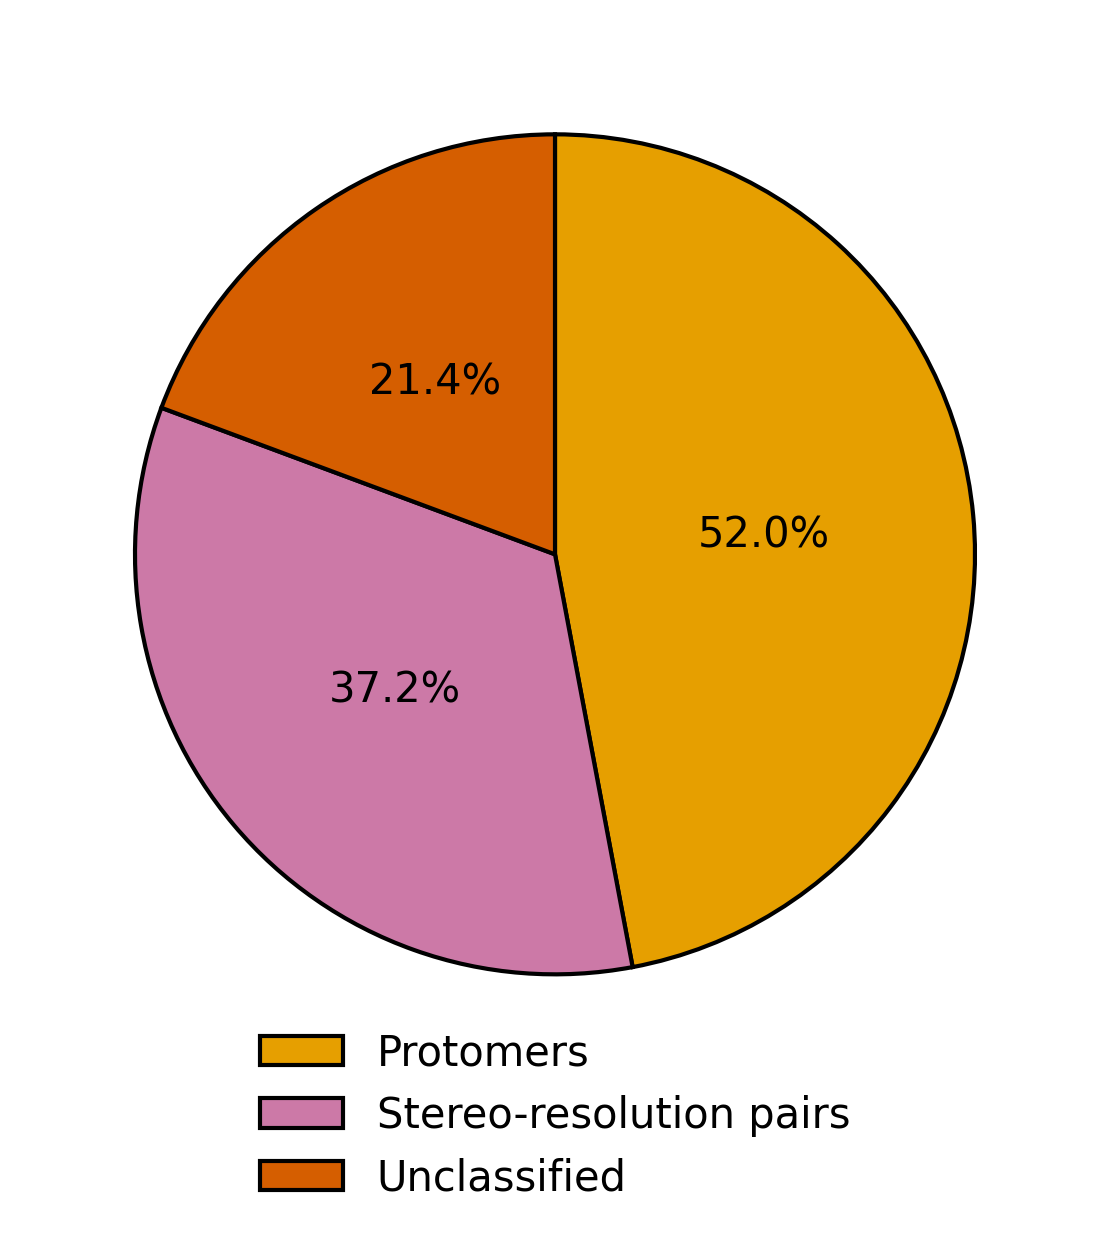

In [70]:
# ------------------------
# Data
# ------------------------

# # Define replacements
replacements = {
    "No classification": "Unclassified",
    "Unresolved (Possible Pipeline Error)": "Unresolved"
}

# Apply transformation
cluster_types = summary_dis["relationship_types"].apply(
    lambda xs: sorted({
        replacements.get(str(t).strip(), str(t).strip())
        for t in (xs or [])
        if pd.notna(t)
    })
)

# disagreement-only, cluster-weighted presence
n_clusters = len(summary_dis)

present_counts = cluster_types.explode().value_counts().sort_values(ascending=False)
assert present_counts.max() <= n_clusters, (present_counts.max(), n_clusters)
present_pct = present_counts / n_clusters * 100

# use these for plotting
rel_counts = present_counts
rel_percentages = present_pct

labels_all = rel_counts.index.tolist()
sizes_all = rel_counts.values
percentages_all = rel_percentages  # Series keyed by label

threshold_pct = 1.0
explicit_rare = {"Enantiomers", "Diastereomers", "Unresolved"}

major_labels = [lbl for lbl in labels_all if percentages_all[lbl] >= threshold_pct]
major_sizes = np.array([rel_counts[lbl] for lbl in major_labels], dtype=float)

rare_labels = [lbl for lbl in labels_all if lbl not in major_labels and lbl in explicit_rare]
rare_count = rel_counts[rare_labels].sum() if rare_labels else 0
rare_pct = rare_count / rel_counts.sum() * 100 if rel_counts.sum() > 0 else 0.0

palette = {
    "Enantiomers": "#009E73",
    "Diastereomers": "#0072B2",
    "Protomers": "#E69F00",
    "Stereo-resolution pairs": "#CC79A7",
    "Unclassified": "#D55E00",
    "Unresolved": "#F0E442",
}
default_colour = "#999999"

major_colours = [palette.get(lbl, default_colour) for lbl in major_labels]

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 12,
    "figure.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(5, 5))

def autopct_fmt(pct):
    total = rel_percentages.sum()
    count = int(round(pct / 100.0 * total))
    return f"{pct:.1f}%"

wedges, texts, autotexts = ax.pie(
    major_sizes,
    labels=None,
    colors=major_colours,
    startangle=90,
    counterclock=False,
    autopct=lambda pct: "",
    pctdistance=0.5,
    wedgeprops=dict(edgecolor="black", linewidth=1.0),
    textprops=dict(fontsize=10),
)

for lbl, autotext in zip(major_labels, autotexts):
    pct_true = rel_percentages[lbl]      # your correct percentage
    autotext.set_text(f"{pct_true:.1f}%")


ax.set_aspect("equal")

# Legend: same layout choices as the other pie
ax.legend(
    wedges,
    major_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=False,
    fontsize=10,
)

# Use the same margins for both pies
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.25)

plt.show()
